In [1]:
# 1.4. Выбираем модельные нозологии: КОАД+РЕАД, ЛУАД, почку (KIRC). Нормируем профили норм ТСГА на
# а) АНТЕ, б) ГТЕХ. Варианты с и без Шамбалы. Смотрим, какие диф. пути между нормой мэчд и нормой здоровой находятся.
# Пересекаем списки диф. путей для АНТЕ и ГТЕХ. Делаем пермутационный тест. Аналогично и по генам

In [2]:
import gc
import multiprocessing
import os
from collections import defaultdict

import numpy as np
import pandas as pd
import qnorm
from rpy2.robjects import FloatVector
from rpy2.robjects.packages import importr
from scipy.stats import gmean, ttest_ind

from utils.permuatation_test import permutation_test
from utils.venn import plot_deg_venn

N_PROCS = multiprocessing.cpu_count() - 1

ANNO = pd.read_csv("data/shambala/raw/Meta.csv", index_col=0)

LUNG = "Lung"
KIDNEY = "Kidney"
COLORECTUM = "Colorectum"

NOSOLOGIES = [COLORECTUM, LUNG, KIDNEY]

RAW_DATASET_NAME = "Raw_3c"
SHAMBALIZED_DATASET_NAME = "00_3c"
DATASET_NAMES = [RAW_DATASET_NAME, SHAMBALIZED_DATASET_NAME]

TRUE_NORMS_PROJECTS = ["GTEX", "Oncobox"]

stats = importr('stats')


def calc_cnrs(df: pd.DataFrame):
    avg_norm = df.filter(like="Normal", axis=1).apply(gmean, axis=1)
    _cnrs = np.log2(df.T / avg_norm)
    _, _pvalues = ttest_ind(
        _cnrs.filter(like="Tumor", axis=0),
        _cnrs.filter(like="Normal", axis=0)
    )
    _cnrs = _cnrs.T
    _cnrs["fdr_bh"] = stats.p_adjust(FloatVector(_pvalues), method="fdr")
    return _cnrs


GENES_NAMESPACE = pd.read_csv("data/experimental/raw/BlC_1_S5_R1_001.txt", sep="\t", index_col=0).index

In [3]:
for dataset_name in DATASET_NAMES:
    for true_norms_project in TRUE_NORMS_PROJECTS:
        target_projects = ["TCGA", true_norms_project]
        target_projects_samples = ANNO[ANNO.plat.isin(target_projects)]

        normalized_data_path = f"data/shambala/{'_'.join(target_projects)}_{dataset_name}_qnorm.tsv"
        if not os.path.exists(normalized_data_path):
            _raw_dataset = pd.read_csv(f"data/shambala/raw/{dataset_name}.csv", index_col=0)
            _normalized_data = qnorm.quantile_normalize(
                _raw_dataset.filter(target_projects_samples.index, axis=1),
                ncpus=N_PROCS
            )
            _normalized_data.round(4).to_csv(normalized_data_path, sep="\t")
            del _raw_dataset
            del _normalized_data
            gc.collect()

        normalized_data = pd.read_csv(normalized_data_path, sep="\t", index_col=0)
        normalized_data.index.name = "SYMBOL"

        dataset_cnrs = list()
        cnrs_path = f"out/shambala/{dataset_name}/{dataset_name}_{'_'.join(target_projects)}_cnrs.tsv"
        for nosology in NOSOLOGIES:
            matched_norm_samples_ids = ANNO[
                (ANNO.type == nosology) &
                (ANNO.tumor_status == "Normal") &
                (ANNO.plat == "TCGA")
                ].index
            true_norm_samples_ids = ANNO[
                (ANNO.type == nosology) &
                (ANNO.tumor_status == "Normal") &
                (ANNO.plat != "TCGA")
                ].index

            matched_norm_samples = normalized_data.filter(matched_norm_samples_ids, axis=1).rename(
                columns=lambda x: f"Tumor__{x}")
            true_norm_samples = normalized_data.filter(true_norm_samples_ids, axis=1).rename(
                columns=lambda x: f"Normal__{x}")
            cnrs = calc_cnrs(pd.concat(
                [matched_norm_samples, true_norm_samples], axis=1
            )).rename(
                columns=lambda x: x.replace("Tumor__", "")
            ).rename(
                columns=lambda x: x.replace("Normal__", "")
            )
            dataset_cnrs.append(cnrs)
        pd.concat(dataset_cnrs, axis=1).to_csv(cnrs_path, sep="\t")

/home/xvvvx/venvs/rna_tool/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
/home/xvvvx/venvs/rna_tool/lib/python3.8/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Permutation test [down]: 100%|██████████| 10000/10000 [00:06<00:00, 1621.12it/s]


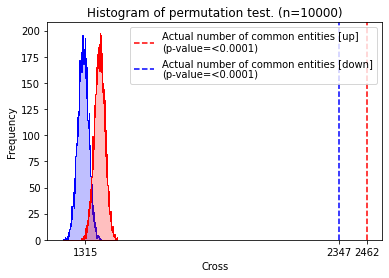

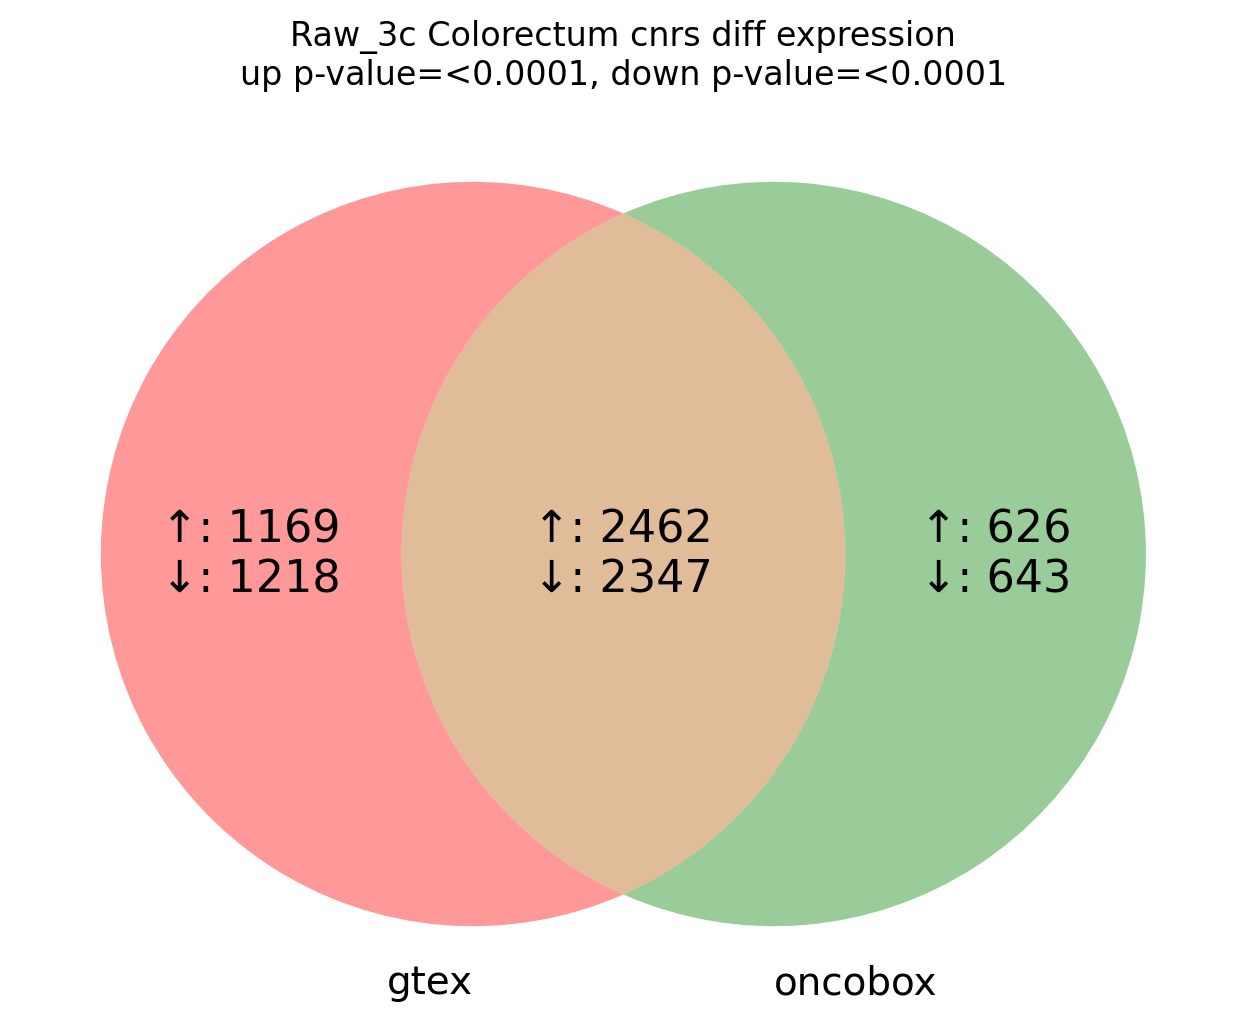

Permutation test [down]: 100%|██████████| 10000/10000 [00:05<00:00, 1712.21it/s]


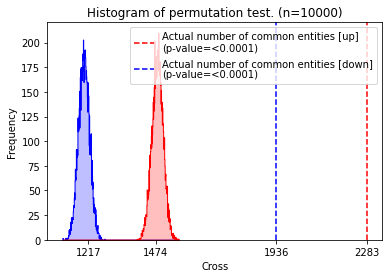

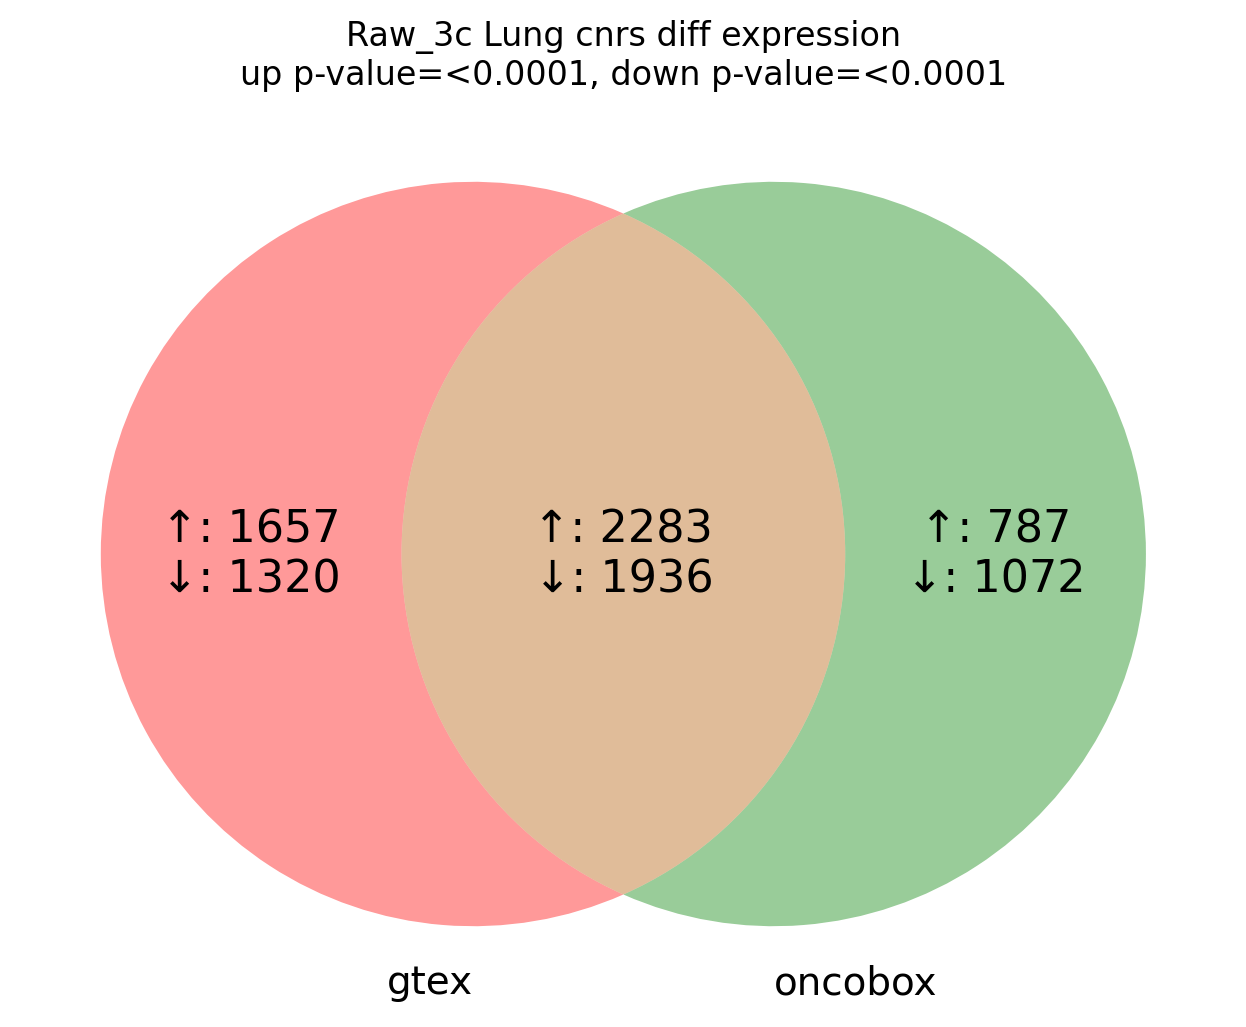

Permutation test [down]: 100%|██████████| 10000/10000 [00:05<00:00, 1719.50it/s]


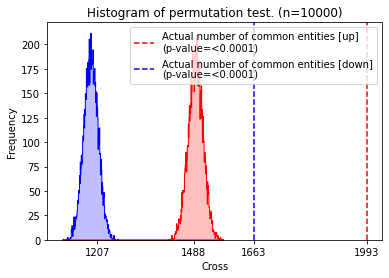

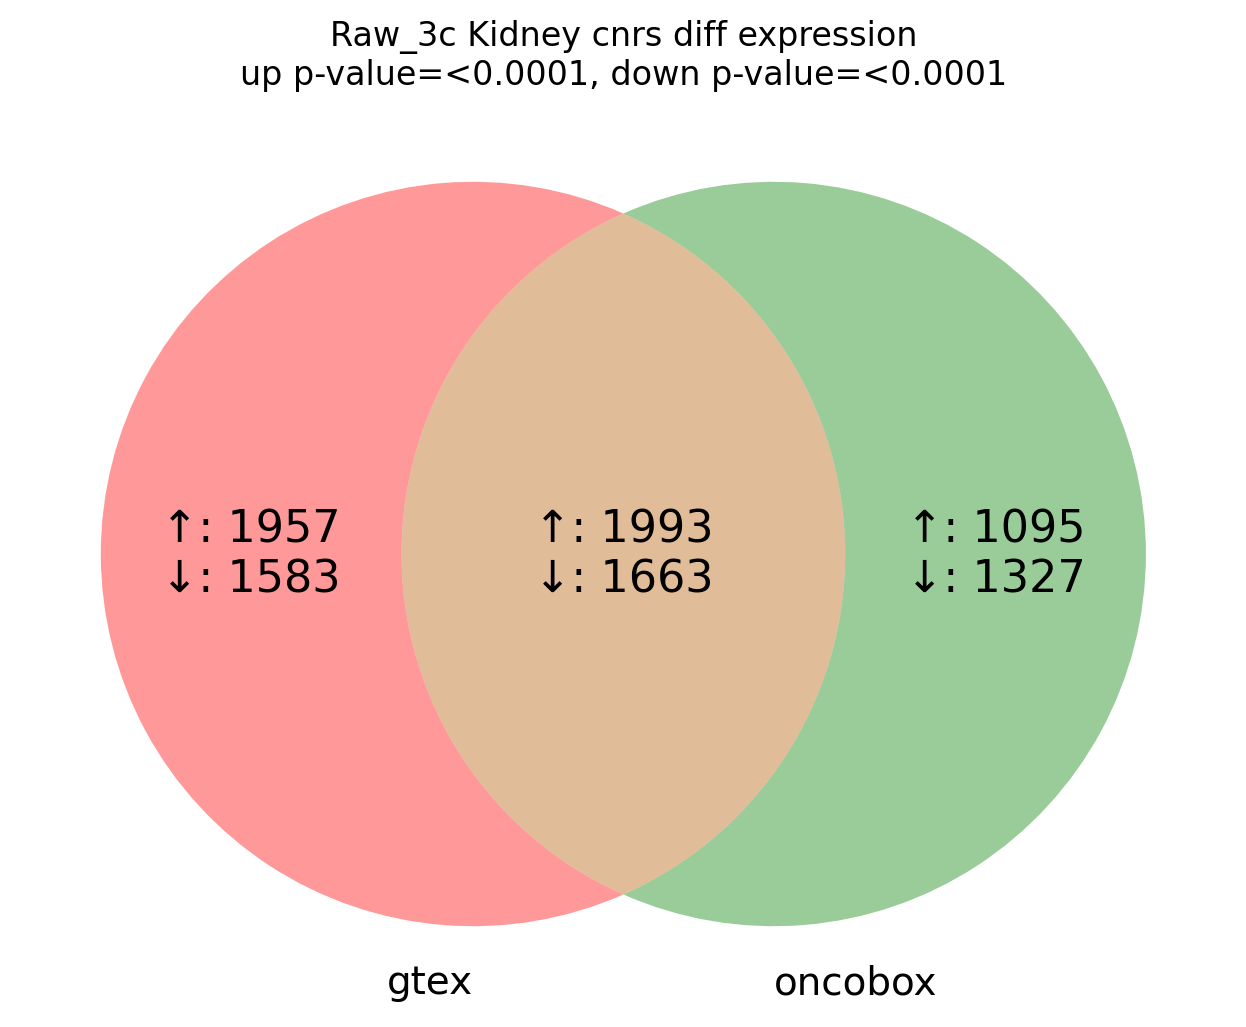

Permutation test [down]: 100%|██████████| 10000/10000 [00:05<00:00, 1714.33it/s]


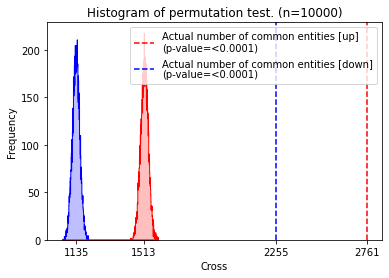

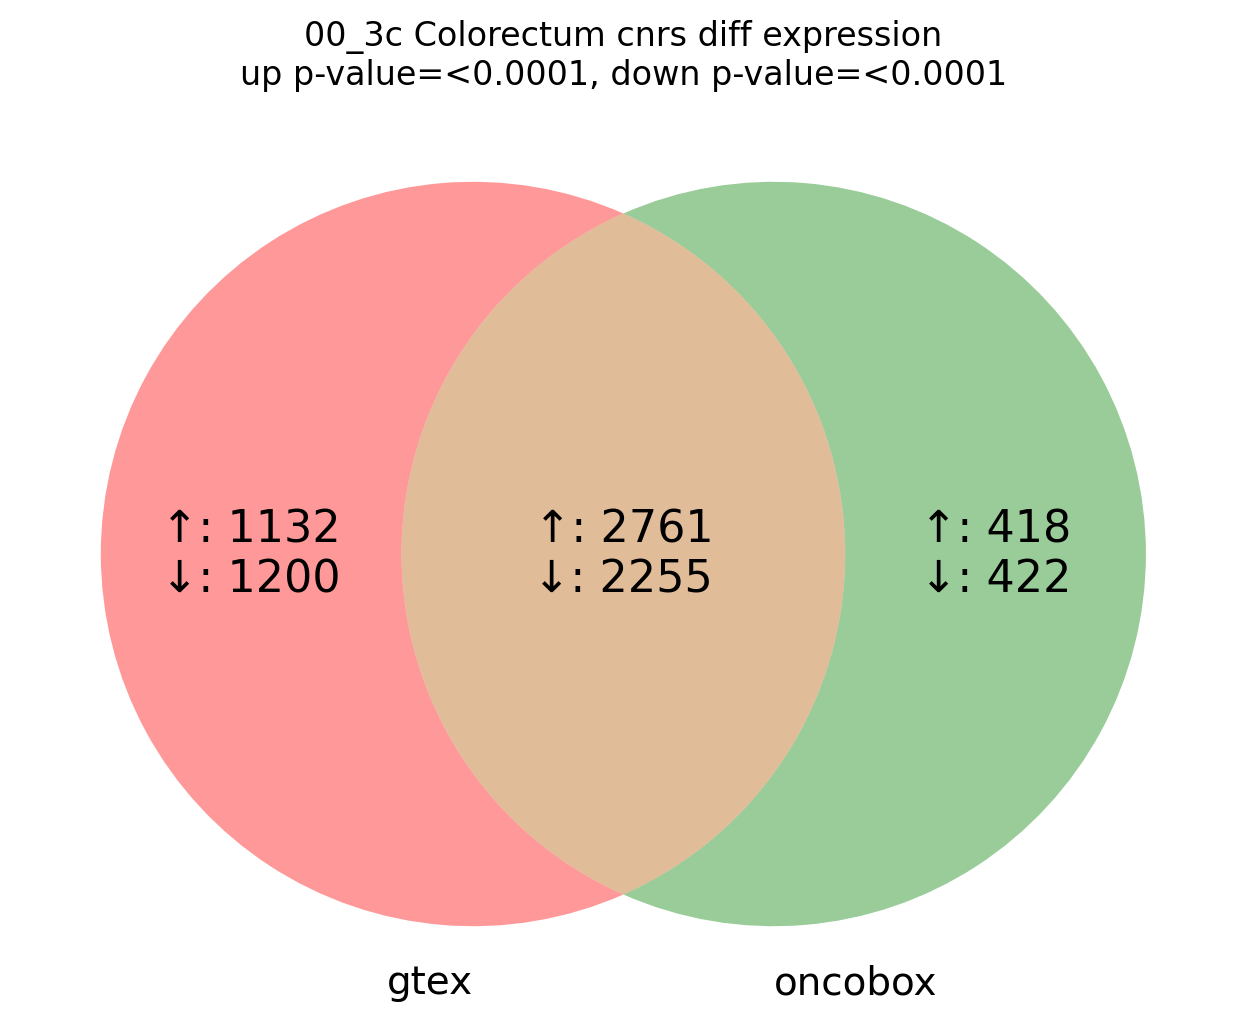

Permutation test [down]: 100%|██████████| 10000/10000 [00:05<00:00, 1714.82it/s]


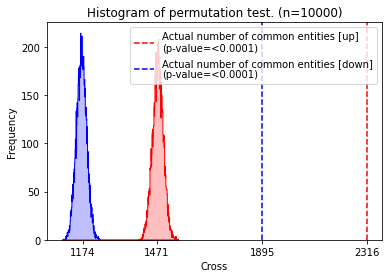

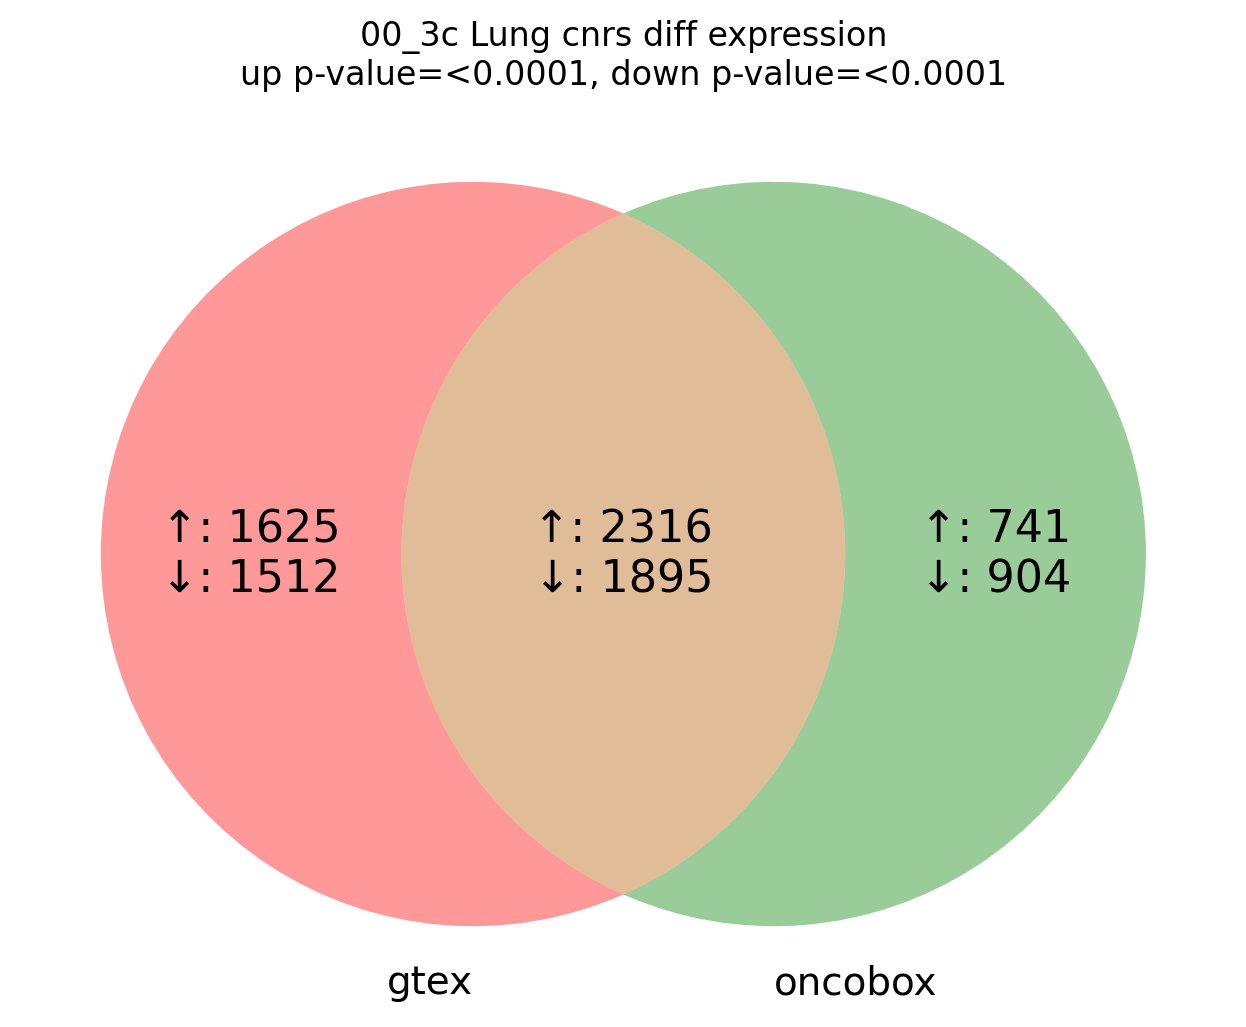

Permutation test [down]: 100%|██████████| 10000/10000 [00:05<00:00, 1730.29it/s]


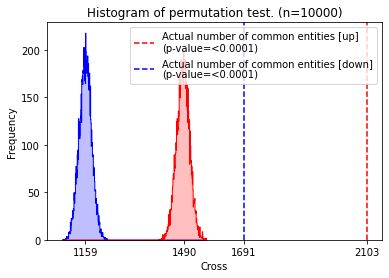

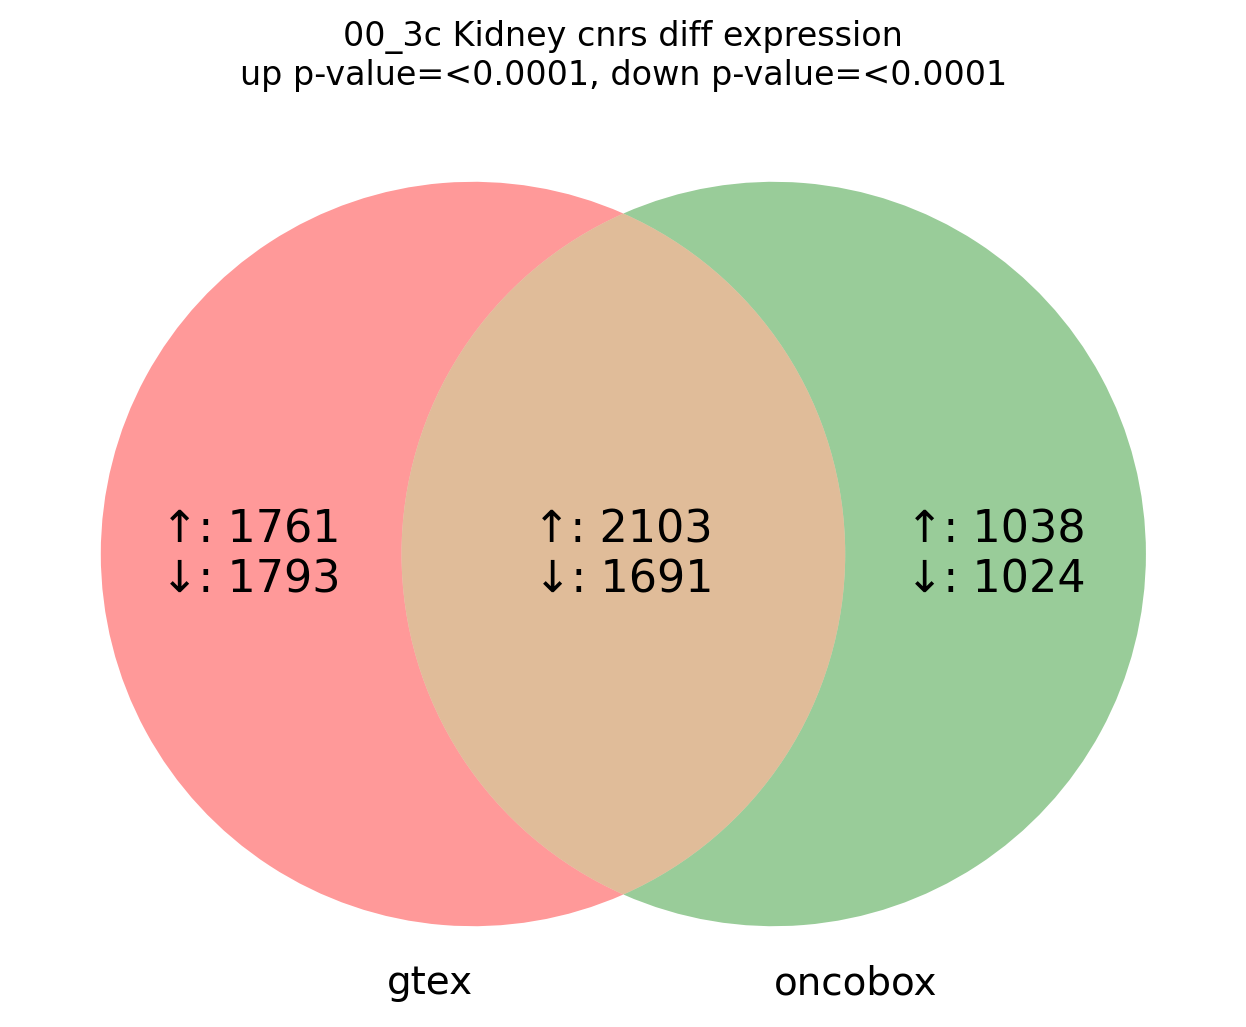

In [6]:
def convert_signal(row):
    if row["fdr_bh"] < 0.05:
        if row["mean_cnr"] > 0:
            return 1
        elif row["mean_cnr"] < 0:
            return -1
    return 0


dataset_intersections = defaultdict(dict)
for dataset_name in DATASET_NAMES:
    gtex_cnrs = pd.read_csv(
        f"out/shambala/{dataset_name}/{dataset_name}_{'_'.join(['TCGA', 'GTEX'])}_cnrs.tsv", sep="\t", index_col=0
    )
    oncobox_cnrs = pd.read_csv(
        f"out/shambala/{dataset_name}/{dataset_name}_{'_'.join(['TCGA', 'Oncobox'])}_cnrs.tsv", sep="\t", index_col=0
    )
    for nosology in NOSOLOGIES:
        matched_norm_samples_ids = ANNO[
            (ANNO.type == nosology) &
            (ANNO.tumor_status == "Normal") &
            (ANNO.plat == "TCGA")
            ].index

        nosology_gtex_normalized_cnrs = pd.concat([
            gtex_cnrs.filter(matched_norm_samples_ids, axis=1).mean(axis=1),
            gtex_cnrs["fdr_bh"]
        ], axis=1)
        nosology_gtex_normalized_cnrs.columns = ["mean_cnr", "fdr_bh"]
        nosology_gtex_normalized_cnr_signals = nosology_gtex_normalized_cnrs.apply(convert_signal, axis=1)

        nosology_oncobox_normalized_cnrs = pd.concat([
            oncobox_cnrs.filter(matched_norm_samples_ids, axis=1).mean(axis=1),
            oncobox_cnrs["fdr_bh"]
        ], axis=1)
        nosology_oncobox_normalized_cnrs.columns = ["mean_cnr", "fdr_bh"]
        nosology_oncobox_normalized_cnr_signals = nosology_oncobox_normalized_cnrs.apply(convert_signal, axis=1)

        diff_cnrs = pd.concat([
            nosology_gtex_normalized_cnr_signals,
            nosology_oncobox_normalized_cnr_signals
        ], axis=1)
        diff_cnrs.columns = ["gtex", "oncobox"]

        # up_lists = [diff_cnrs[diff_cnrs.gtex == 1].index, diff_cnrs[diff_cnrs.oncobox == 1].index]
        # up_intersection, up_pvalue = permutation_test(
        #     GENES_NAMESPACE,
        #     up_lists, plot=True, group_name=f"{nosology} upregulation"
        # )
        # down_lists = [diff_cnrs[diff_cnrs.gtex == -1].index, diff_cnrs[diff_cnrs.oncobox == -1].index]
        # down_intersection, down_pvalue = permutation_test(
        #     GENES_NAMESPACE,
        #     down_lists, plot=True, group_name=f"{nosology} downregulation"
        # )

        intersections = permutation_test(
            diff_cnrs,
            [1, -1],
            value_labels={
                1: "up",
                -1: "down"
            },
            value_colors={
                1: "red",
                -1: "blue"
            },
            show_plot=True
        )

        plot_deg_venn(
            diff_cnrs,
            title=f"{dataset_name} {nosology} cnrs diff expression\n"
                  f"up p-value={'<0.0001' if intersections[1]['pvalue'] < .000_1 else round(intersections[1]['pvalue'], 4)}, "
                  f"down p-value={'<0.0001' if intersections[-1]['pvalue'] < .000_1 else round(intersections[-1]['pvalue'], 4)}",
            out=f"out/shambala/{dataset_name}/venns/nosology_venn.png"
        )
        dataset_intersections[dataset_name][nosology] = dict(up=intersections[1]["intersection"], down=intersections[-1]["intersection"])

            0    1    2    3    4    5
C5orf30   1.0  1.0  1.0 -1.0  1.0  1.0
COX6B1    1.0  1.0  1.0  1.0  1.0  1.0
ADAM15    1.0  1.0 -1.0  NaN -1.0  NaN
YEATS4    1.0  1.0  1.0  1.0  1.0  1.0
ESRP2     1.0  1.0  1.0  1.0 -1.0  NaN
...       ...  ...  ...  ...  ...  ...
PQLC2     NaN  NaN  NaN  NaN  NaN -1.0
FASTK     NaN  NaN  NaN  NaN  NaN -1.0
HSPA14    NaN  NaN  NaN  NaN  NaN -1.0
SLC35A1   NaN  NaN  NaN  NaN  NaN -1.0
HNRNPUL2  NaN  NaN  NaN  NaN  NaN -1.0

[6325 rows x 6 columns]


Permutation test [down]: 100%|██████████| 10000/10000 [00:11<00:00, 848.96it/s]


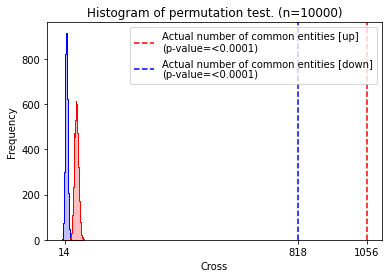

{1: {'intersection': ['COX6B1',
   'VAPA',
   'YEATS4',
   'SCAMP1',
   'PTPRF',
   'ASB13',
   'SLC39A1',
   'KBTBD4',
   'DNAJB9',
   'MLLT3',
   'FDFT1',
   'C14orf166',
   'TCTN3',
   'POLE3',
   'CTR9',
   'UNG',
   'CCDC47',
   'SEL1L3',
   'CLPTM1',
   'MGST2',
   'AIMP2',
   'LTA4H',
   'EMC3',
   'ARG2',
   'ADRM1',
   'ACP2',
   'ARSD',
   'SNX24',
   'RAB1B',
   'BAD',
   'PIGB',
   'PDPK1',
   'AGGF1',
   'PPP2R5D',
   'SSR3',
   'FAM105A',
   'ENPP4',
   'IMP4',
   'RABL3',
   'DNASE1',
   'GALNT12',
   'KCNQ1',
   'RUVBL2',
   'SDC1',
   'MCM4',
   'ZDHHC4',
   'RNF2',
   'IL13RA1',
   'LAPTM4B',
   'PCBP1',
   'YIPF6',
   'FH',
   'NDE1',
   'IMPACT',
   'IFT52',
   'NAGA',
   'THAP11',
   'ANXA3',
   'LPCAT3',
   'PDCD10',
   'NUP88',
   'CCNC',
   'VPS51',
   'HLA-DPA1',
   'ST14',
   'PSMD2',
   'METTL13',
   'NBR1',
   'CCDC90B',
   'CSNK2A1',
   'ANXA11',
   'SEPHS1',
   'GPSM2',
   'SDCBP',
   'PIAS1',
   'CRIPT',
   'SLC25A20',
   'FAM120A',
   'DENR',
   'NEU1',


In [9]:
from itertools import repeat

intersections = defaultdict(list)

merged_intersections = pd.concat([
    pd.concat([
        pd.Series(dict(zip(dataset_intersections[dataset][nosology]["up"], repeat(1)))),
        pd.Series(dict(zip(dataset_intersections[dataset][nosology]["down"], repeat(-1)))),
    ])
    for nosology in NOSOLOGIES
    for dataset in [RAW_DATASET_NAME, SHAMBALIZED_DATASET_NAME]
], axis=1)

print(merged_intersections)

permutation_test(
    merged_intersections,
    [1, -1],
    value_labels={
        1: "up",
        -1: "down"
    },
    value_colors={
        1: "red",
        -1: "blue"
    },
    show_plot=True
)

# for regulation in ["up", "down"]:
#     raw_dataset_regulations = dataset_intersections[RAW_DATASET_NAME][nosology][regulation]
#     shambalized_dataset_regulations = dataset_intersections[SHAMBALIZED_DATASET_NAME][nosology][regulation]
#     curr_intersection, pvalue = permutation_test(
#         GENES_NAMESPACE,
#         [raw_dataset_regulations, shambalized_dataset_regulations], plot=True,
#         group_name=f"{nosology} {regulation}regulated\n"
#                    f"genes intersection"
#     )
#     intersections[regulation].append(curr_intersection)

In [ ]:
for regulation in ["up", "down"]:
    print(len(intersections[regulation]))
    print([len(x) for x in intersections[regulation]])
    print(len(GENES_NAMESPACE))
    intersection, _ = permutation_test(
        GENES_NAMESPACE,
        intersections[regulation], plot=True,
        group_name=f"Intersection of {regulation}regulated\n"
                   f"genes between nosologies and datasets"
    )
    with open(f"out/shambala/final_cnrs_{regulation}.txt", "w") as f:
        for pathway in intersection:
            f.write(f"{pathway}\n")